In [142]:
import pandas as pd
from matplotlib import pyplot as plt

# Preprocessing

In [3]:
df = pd.read_pickle('../bucket_1_dmv/BTC-USD-60.pkl')
df.head()

,time,low,high,open,close,volume
0,1451624340,436.12,436.13,436.12,436.12,6.139053
1,1451624280,436.02,436.36,436.02,436.13,0.312749
2,1451624220,436.03,437.12,437.02,436.03,23.060550
3,1451624160,437.02,437.07,437.02,437.07,1.017000
4,1451624100,437.02,437.11,437.11,437.02,1.308700


In [4]:
df['date'] = pd.to_datetime(df['time'],unit='s').dt.date
group = df.groupby('date')
Daily_Close_Price = group['close'].mean()
Daily_Close_Price=Daily_Close_Price.reset_index()
Daily_Close_Price=Daily_Close_Price.set_index('date')
daily = Daily_Close_Price
daily['datetime'] = pd.to_datetime(daily.index)
daily=daily.set_index('datetime')
daily.head()

,close
datetime,
2016-01-01,433.300405
2016-01-02,435.083883
2016-01-03,431.338427
2016-01-04,433.626442
2016-01-05,433.373114


Text(0,0.5,'Weekly bitcoin price')

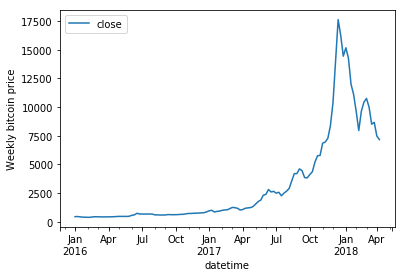

In [43]:
weekly = daily.resample('W').mean()
weekly.plot()
plt.ylabel('Weekly bitcoin price')

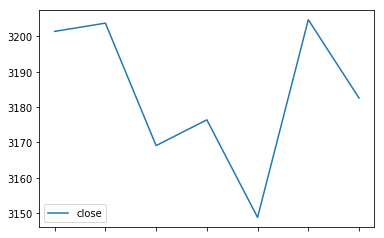

In [47]:
by_weekday = daily.groupby(daily.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot()

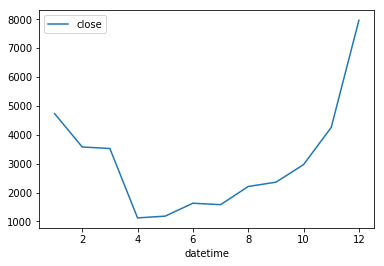

In [49]:
by_month = daily.groupby(daily.index.month).mean()
by_month.plot()

# Baseline: moving average

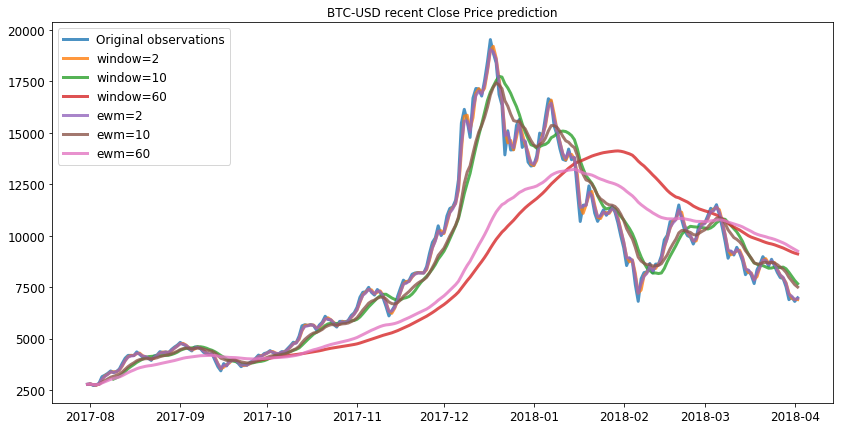

In [234]:
start = 577
rec = Daily_Close_Price.close.iloc[start:-1]
rec_rroll_d2 = rec.rolling(window=2).mean()
rec_rroll_d10 = rec.rolling(window=10).mean()
rec_rroll_d60 = rec.rolling(window=60).mean()

rec_ewm_d2 = rec.ewm(span = 2).mean()
rec_ewm_d10 = rec.ewm(span = 10).mean()
rec_ewm_d60 = rec.ewm(span = 60).mean()

plt.figure(figsize=(14,7))
plt.plot(rec.index,rec,lw=3,alpha=0.8,label = 'Original observations')
plt.plot(rec.index,rec_rroll_d2,lw=3,alpha=0.8,label = 'window=2')
plt.plot(rec.index,rec_rroll_d10,lw=3,alpha=0.8,label = 'window=10')
plt.plot(rec.index,rec_rroll_d60,lw=3,alpha=0.8,label = 'window=60')
plt.plot(rec.index,rec_ewm_d2,lw=3,alpha=0.8,label = 'ewm=2')
plt.plot(rec.index,rec_ewm_d10,lw=3,alpha=0.8,label = 'ewm=10')
plt.plot(rec.index,rec_ewm_d60,lw=3,alpha=0.8,label = 'ewm=60')
plt.title('BTC-USD recent Close Price prediction')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [14]:
import math
window_size = 1
predict_len = 1
start_idx = 577
end_idx = 741

#  Predict one out-of-sample.
def ma_predict_one(window_size,predict_len,start):
    predict_from_start = pd.DataFrame(columns = ['date','predict_price'])
    for i in range(start, start + predict_len):
        cur_ts = daily.index[i]
        cur_sum = 0
        for j in range(window_size,0,-1):
            if (i - start - j < 0):
                cur_sum += daily.iloc[i - j].close
            else:
                cur_sum += predict_from_start.iloc[i - start - j].predict_price
        cur_predict = cur_sum / window_size
        predict_from_start = predict_from_start.append({'date': cur_ts,'predict_price':cur_predict}, ignore_index=True)
    predict_from_start = predict_from_start.set_index('date')
    # calc rmse of relative error
    err_sum = 0
    smaep = 0
    for i in range(predict_len):
#         average of root of square of relative error.
        err_sum += math.sqrt(pow((predict_from_start.iloc[i].predict_price - \
                                  daily.iloc[start+i].close)/daily.iloc[start+i].close, 2))
        smaep += abs((predict_from_start.iloc[i].predict_price - \
                                  daily.iloc[start+i].close)/(daily.iloc[start+i].close + predict_from_start.iloc[i].predict_price))
    avr_err = err_sum/predict_len
    avr_smaep = smaep/predict_len
    return avr_err,avr_smaep
ma_predict_one(window_size,predict_len,start_idx)

(0.02979741430633782, 0.015124035732521817)

In [15]:
# Calculate baseline error. (predict_len fixed to 1)
start = 577
end = 741
def ma_baseline(start,end,window_size):
    err_sum = 0
    err_s_sum = 0
    for i in range (start,end):
        cur_err, cur_s_err = ma_predict_one (window_size, 1, i)
        err_sum += cur_err
        err_s_sum += cur_s_err
    avr_err = err_sum / (end - start)
    avr_s_err = 2 * err_s_sum / (end - start)
    return avr_s_err
for i in range (1,11):
    print("window size = " + str(i) + ", smaep = " + str(ma_baseline(start,end,i)))

window size = 1, smaep = 0.03525807970414379
window size = 2, smaep = 0.043197397034775445
window size = 3, smaep = 0.05148960981218468
window size = 4, smaep = 0.05856351098237654
window size = 5, smaep = 0.06581781834827982
window size = 6, smaep = 0.07162849177318477
window size = 7, smaep = 0.0771741647062072
window size = 8, smaep = 0.0827021690229575
window size = 9, smaep = 0.08854040347929493
window size = 10, smaep = 0.09440042301292213


**So our baseline model can reach smaep of 0.035.**

# Time series analysis

### Stationary test. 
(ARIMA model requires time series to be stationary)

In [16]:
from statsmodels.tsa.stattools import adfuller
def stationary_test(test_series):
    result = adfuller(test_series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [17]:
stationary_test(daily.close)

ADF Statistic: -1.543930
p-value: 0.511679
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


One-order difference is staionary. This means in arima model, we should set order to 1 or higher.

In [18]:
price_change = pd.DataFrame()
price_change['close'] = daily["close"]-Daily_Close_Price["close"].shift(1)
price_change = price_change.dropna()
stationary_test(price_change.close)

ADF Statistic: -4.898767
p-value: 0.000035
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


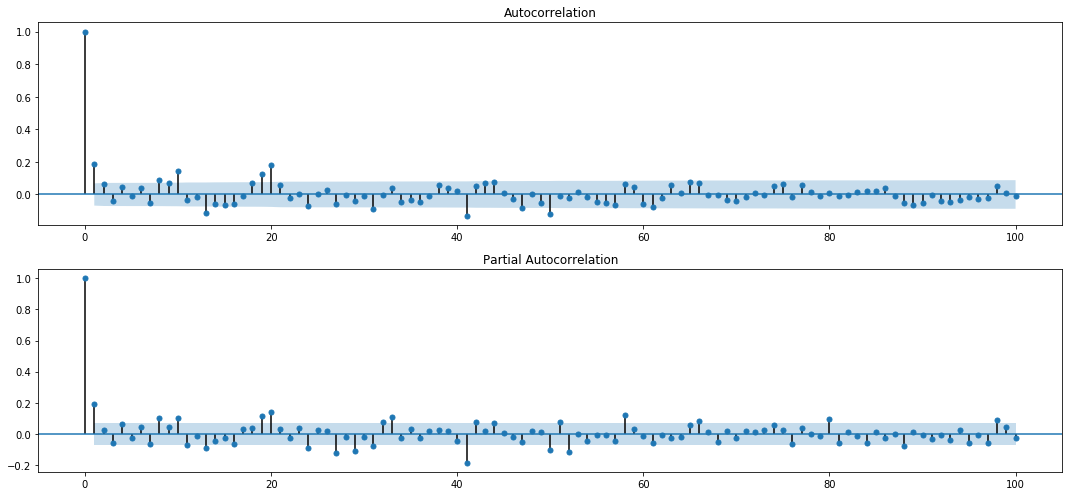

In [10]:
import statsmodels.api as sm
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(price_change.close.values.squeeze(), lags=100, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(price_change.close.values.squeeze(), lags=100, ax=ax)
plt.tight_layout()
plt.show()

### Time series forecasting using arima

In [6]:
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [202]:
price_change.iloc[741]

close   -54.051396
Name: 2018-01-12 00:00:00, dtype: float64

In [12]:
from statsmodels.tsa.arima_model import _arma_predict_out_of_sample

for p in range(8):
    for q in range(8):
        if (p == 0 and q == 0):
            continue
        try:
            dtrain, dtest = daily.iloc[0:576].copy(), daily.iloc[576:741].copy()
            xdtrain = [x for x in dtrain.close]
            res1 = sm.tsa.SARIMAX(dtrain, order = (p,1,q)).fit()

            predict = []
            for i in range(577,741):
                mod2 = sm.tsa.SARIMAX(xdtrain,order = (p,1,q))
                res2 = mod2.filter(res1.params)
                predict.append(res2.forecast(1)[0])
                xdtrain.append(daily.iloc[i].close)
            err_s_sum = 0
            for i in range (577,741):
                err_s_sum += abs((predict[i - 577] - daily.iloc[i].close)/(predict[i - 577] + daily.iloc[i].close))
            smaep = 2 * err_s_sum / (741 - 577)
            print("p = " + str(p) + " q = " + str(q) + " smaep = " + str(smaep))
        except:
            pass

p = 0 q = 1 smaep = 0.034859632234840614
p = 0 q = 2 smaep = 0.036045306852904004
p = 0 q = 3 smaep = 0.036048778808218995
p = 0 q = 4 smaep = 0.03597486106064025
p = 0 q = 5 smaep = 0.03585500299323606
p = 0 q = 6 smaep = 0.036020356338776656
p = 0 q = 7 smaep = 0.035875259975078636
p = 1 q = 0 smaep = 0.033597143200710965
p = 1 q = 1 smaep = 0.0359514154693031
p = 1 q = 2 smaep = 0.036048479250083275
p = 1 q = 3 smaep = 0.03612510285965879
p = 1 q = 4 smaep = 0.03620429967548558
p = 1 q = 5 smaep = 0.03603527941616996
p = 1 q = 6 smaep = 0.03608852981683337


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 1 q = 7 smaep = 0.03576654043690257
p = 2 q = 0 smaep = 0.03466682462424942
p = 2 q = 1 smaep = 0.036061732168981106
p = 2 q = 2 smaep = 0.03616652711590432
p = 2 q = 3 smaep = 0.03616779370697745


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 2 q = 4 smaep = 0.03644155017129734


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 2 q = 5 smaep = 0.03611093721178041


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 2 q = 6 smaep = 0.036119751511571124


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 2 q = 7 smaep = 0.035765039643990484
p = 3 q = 0 smaep = 0.03536897158709814
p = 3 q = 1 smaep = 0.035981332097617995


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 3 q = 3 smaep = 0.03568005103032783


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 3 q = 5 smaep = 0.03599624073344519


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 3 q = 6 smaep = 0.03575188165156887
p = 4 q = 0 smaep = 0.03581061189653517
p = 4 q = 1 smaep = 0.03579870623069746


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 4 q = 4 smaep = 0.03681687376765233


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 4 q = 5 smaep = 0.03557437017176241


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 4 q = 6 smaep = 0.03605099768501645
p = 5 q = 0 smaep = 0.035701109428214806
p = 5 q = 1 smaep = 0.03581260485325416


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 5 q = 2 smaep = 0.0381663488728431
p = 5 q = 3 smaep = 0.03588825481645117


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 5 q = 5 smaep = 0.03702979123210761


/usr/local/lib/python3.6/site-packages/statsmodels/tsa/statespace/tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)


p = 5 q = 6 smaep = nan
p = 6 q = 0 smaep = 0.03623701762054251
p = 6 q = 1 smaep = 0.03621839546906063


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 6 q = 2 smaep = 0.036170832649853366


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p = 6 q = 5 smaep = 0.03678135257517347
p = 7 q = 0 smaep = 0.03614643531276584
p = 7 q = 1 smaep = 0.035965937575459815
p = 7 q = 2 smaep = 0.036088933935930545


** So our arima forecasting model could reach smaep of 0.03359 when p = 1,d = 1 and q = 0. **